In [1]:
import typing
import lzma
import os
from pathlib import Path
from types import MappingProxyType, SimpleNamespace

import cbor2
import attrs
import tqdm.auto
import jax
import jax.numpy as jnp
from flax import nnx
import optax
import jaxtyping as jt
import numpy as np
import pandas as pd

from arc25.symmetry import SymOp, transform_vector
from arc25 import serialisation
from arc25.dsl.types import Vector, Dir4
from arc25.vision.symrep import SymRep, SymDecomp, SymDecompDims, standard_rep
from arc25.vision.linear import SymmetricLinear
from arc25.vision.rope import QKV, attention_RoPE_with_global
from arc25.vision.fields import Field, FieldDims
from arc25.vision.attention import FieldAttention
from arc25.vision.classification import ARCClassifier


In [2]:

os.environ["XLA_FLAGS"]="--xla_force_host_platform_device_count=8"

In [3]:
proj_root = Path("..").resolve()
data_root = proj_root / "data"

In [4]:
with lzma.LZMAFile(data_root/"re-arc.cbor.xz","rb") as fh:
    src_data = serialisation.deserialise(cbor2.load(fh))

In [5]:
dataset = []
size_cuts = np.r_[8,16,24,30]
#size_cuts = np.r_[20,30]
skipped = []
for k,v in tqdm.auto.tqdm(src_data.items()):
    for i,iop in enumerate(v):
        for kk in ["input","output"]:
            vv = getattr(iop,kk)
            if any(s>30 for s in vv.shape):
                skipped.append(vv)
                continue
            gs = tuple(int(size_cuts[np.searchsorted(size_cuts,s)]) for s in vv.shape)
            dataset.append(dict(
                image = vv._data,
                shape = vv.shape,
                size = int(np.prod(vv.shape)),
                grouping_shape = gs,
                challenge = k,
                type = kk,
            ))
print(f"Skipped {len(skipped)} out of {len(skipped)+len(dataset)} due to out-of-range shape")
datasrc = pd.DataFrame(dataset)
datasrc.head()

  0%|          | 0/400 [00:00<?, ?it/s]

Skipped 258 out of 800000 due to out-of-range shape


,image,shape,size,grouping_shape,challenge,type
0,"[[7, 7, 7, 7, 6, 7, 7, 7, 7], [7, 7, 7, 7, 7, ...","(6, 9)",54,"(8, 16)",a85d4709,input
1,"[[4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 3, 3, 3, 3, ...","(6, 9)",54,"(8, 16)",a85d4709,output
2,"[[6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6], [6, 6, ...","(15, 12)",180,"(16, 16)",a85d4709,input
3,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 3, ...","(15, 12)",180,"(16, 16)",a85d4709,output
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,...","(2, 24)",48,"(8, 24)",a85d4709,input


In [6]:
total_waste = 0
total_cells = 0
min_grp = 1000000
for gs,grp in datasrc.groupby("grouping_shape"):
    s = gs[0]*gs[1]*grp.shape[0]
    n = grp["size"].sum()
    util = n/s
    waste = s-n
    total_waste += waste
    total_cells += n
    min_grp = min(min_grp, grp.shape[0])
    print(f"Group {str(gs):8s} has {grp.shape[0]:6} with an average utilisation of {util*100:.0f} %, wasting {waste*1e-3:.1f}k cells")
print(f"Total waste: {total_waste*1e-6:.1f}M cells vs {total_cells*1e-6:.1f}M useful cells")
print(f"Maximum batch size / minimum group size: {min_grp}")

Group (8, 8)   has  92827 with an average utilisation of 31 %, wasting 4117.9k cells
Group (8, 16)  has  37446 with an average utilisation of 53 %, wasting 2269.0k cells
Group (8, 24)  has  27492 with an average utilisation of 61 %, wasting 2076.1k cells
Group (8, 30)  has  17736 with an average utilisation of 65 %, wasting 1495.0k cells
Group (16, 8)  has  36507 with an average utilisation of 53 %, wasting 2207.4k cells
Group (16, 16) has  85430 with an average utilisation of 62 %, wasting 8356.8k cells
Group (16, 24) has  68870 with an average utilisation of 68 %, wasting 8495.4k cells
Group (16, 30) has  46297 with an average utilisation of 72 %, wasting 6172.2k cells
Group (24, 8)  has  26534 with an average utilisation of 62 %, wasting 1951.6k cells
Group (24, 16) has  69817 with an average utilisation of 68 %, wasting 8618.7k cells
Group (24, 24) has  83898 with an average utilisation of 73 %, wasting 12947.7k cells
Group (24, 30) has  51217 with an average utilisation of 78 %, w

In [7]:
import xarray as xa

challenge_index = pd.CategoricalIndex(sorted(datasrc.challenge.unique()))
itype_index = pd.CategoricalIndex(sorted(datasrc.type.unique()))
challenge_index, itype_index

(CategoricalIndex(['007bbfb7', '00d62c1b', '017c7c7b', '025d127b', '045e512c',
                   '0520fde7', '05269061', '05f2a901', '06df4c85', '08ed6ac7',
                   ...
                   'f8b3ba0a', 'f8c80d96', 'f8ff0b80', 'f9012d9b', 'fafffa47',
                   'fcb5c309', 'fcc82909', 'feca6190', 'ff28f65a', 'ff805c23'],
                  categories=['007bbfb7', '00d62c1b', '017c7c7b', '025d127b', ..., 'fcc82909', 'feca6190', 'ff28f65a', 'ff805c23'], ordered=False, dtype='category', length=400),
 CategoricalIndex(['input', 'output'], categories=['input', 'output'], ordered=False, dtype='category'))

In [8]:
padded_data = {}
for gs,grp in datasrc.groupby("grouping_shape"):
    n = grp.shape[0]
    images = np.zeros((n,)+gs,"i1")
    sizes = np.zeros((n,2),int)
    challenges = np.zeros((n,),int)
    itype = np.zeros((n,),int)
    for i,(_,row) in enumerate(grp.iterrows()):
        h,w = row["shape"]
        images[i,:h,:w] = row.image
        sizes[i,:] = h,w
        challenges[i] = challenge_index.get_loc(row.challenge)
        itype[i] = itype_index.get_loc(row.type)
    data = xa.Dataset(
        dict(
            images = (("idx","row","col"), images),
            sizes = (("idx","dim"), sizes),
            challenges = (("idx",),challenges),
            itype = (("idx",),itype),
        ),
        coords = dict(
            dim = pd.Index(["row","col"]),
        ),
    )
    padded_data[gs] = data
data

<xarray.Dataset> Size: 39MB
Dimensions:     (idx: 41313, row: 30, col: 30, dim: 2)
Coordinates:
  * dim         (dim) object 16B 'row' 'col'
Dimensions without coordinates: idx, row, col
Data variables:
    images      (idx, row, col) int8 37MB 6 6 6 6 6 6 6 6 6 ... 0 0 0 0 0 0 0 0
    sizes       (idx, dim) int64 661kB 29 30 29 30 28 27 ... 29 26 25 28 25 28
    challenges  (idx) int64 331kB 261 261 261 261 261 ... 233 233 233 233 233
    itype       (idx) int64 331kB 0 1 0 1 0 1 0 1 0 1 0 ... 0 1 0 1 0 1 0 1 0 1

In [9]:
def make_dataset(batch_size: int, rngs:nnx.Rngs):
    weights = {}
    for gs,data in padded_data.items():
        weights[gs] = data.idx.size
    logits = np.log(np.array(list(weights.values())))
    keys = tuple(weights.keys())
    rng = rngs
    warmup = 0
    while True:
        if warmup is None or warmup>=len(keys):
            warmup = None
            gs = keys[rng.categorical(logits)]
        else:
            gs = keys[warmup]
            warmup += 1
        data = padded_data[gs]
        assert data.idx.size >= batch_size
        i = set()
        while len(i) < batch_size:
            j = rng.randint((batch_size-len(i),),0,data.idx.size)
            i.update(int(v) for v in j)
        i = np.array(sorted(i))
        images = data.images.to_numpy()[i]
        sizes = data["sizes"].to_numpy()[i]
        labels = data.challenges.to_numpy()[i]
        yield dict(
            inputs = dict(image=images, size=sizes),
            label = labels,
        ), warmup is not None

In [10]:
import dataclasses
from dataclasses import dataclass

In [11]:
@dataclass(frozen=True)
class ModelConfig:
    num_classes: int = 1000
    embed_dim: int = 256

@dataclass(frozen=True)
class TrainConfig:
    """Configuration for the training script."""
    seed: int = 42
    global_batch_size: int = 128  # across all devices
    ref_batch: int = 1024 # all learning rates refer to this batch size
    ref_epoch: int = 800000 # number of images that we call one epoch in reporting
    # Optimiser
    learning_rate: float = 3e-4
    betas: tuple[float, float] = (0.9, 0.999)
    eps: float = 1e-8
    weight_decay: float = 0.05
    grad_clip_norm: float = 1.0
    # Schedule    
    # in units of ref_epoch images!
    num_train_epochs: int = 100
    warmup_epochs: float = 1
    log_every_steps: int = 50

    # TODO: EMA


In [25]:

@jax.tree_util.register_dataclass
@dataclass(frozen=True)
class TrainState:
    """A frozen dataclass to hold the training state."""
    config: TrainConfig = dataclasses.field(metadata=dict(static=True))
    model_def: nnx.GraphDef = dataclasses.field(metadata=dict(static=True))
    trainable_state: nnx.State
    other_state: nnx.State
    tx: optax.GradientTransformation = dataclasses.field(metadata=dict(static=True))
    opt_state: optax.OptState
    # ema_params: nnx.Params

    @classmethod
    def make(
        cls,
        model: nnx.Module,
        config: TrainConfig,
        *,
        rngs: nnx.Rngs,
    ) -> typing.Self:
        """Initializes the model, optimizer, and the combined training state."""

        step_scale = (config.global_batch_size / config.ref_batch)
        epoch_scale = config.ref_epoch / config.global_batch_size
        # Create the learning rate schedule (warmup + cosine decay is standard for ViTs)
        # with Linear LR scaling
        lr = config.learning_rate * step_scale
        zero_lr = lr * 0.001
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=zero_lr,
            peak_value=config.learning_rate,
            warmup_steps=int(round(config.warmup_epochs*epoch_scale)),
            decay_steps=int(round((config.num_train_epochs - config.warmup_epochs)*epoch_scale)),
            end_value=zero_lr,
        )
    
        # Create the AdamW optimizer with gradient clipping
        tx = optax.chain(
            optax.clip_by_global_norm(config.grad_clip_norm),
            optax.adamw(
                learning_rate=lr_schedule,
                weight_decay=config.weight_decay,
                b1=config.betas[0],
                b2=config.betas[1], 
                eps=config.eps,
            ),
        )
    
        # Split the model into its static definition (GraphDef) and dynamic state (State)
        model_def, trainable_state, other_state = nnx.split(model,nnx.Param, ...)
        
        # Initialize optimizer state from the model's parameters
        opt_state = tx.init(trainable_state)
        
        return cls(
            config=config,
            model_def=model_def,
            trainable_state=trainable_state,
            other_state=other_state,
            tx=tx,
            opt_state=opt_state
        )

    def model_stats(self):
        stats = {}
        for k in ["trainable_state","other_state","opt_state"]:
            v = getattr(self, k)
            leaves = jax.tree_util.tree_leaves(v)
            total_params = sum((leaf.size for leaf in leaves), start=0)
            total_bytes = sum((leaf.nbytes for leaf in leaves), start=0)
            stats[k] = SimpleNamespace(params=total_params,bytes=total_bytes)
        
        return SimpleNamespace(**stats)

    def batch_stats(self, batch_size:int|None=None,shape:tuple[int,int] = (30,30)):
        def inference(state: TrainState, batch):
            model = nnx.merge(self.model_def, self.trainable_state, self.other_state)
            model.eval()
            inputs = batch["inputs"]
            return model(inputs["image"], inputs["size"])
        def train(state: TrainState, batch):
            model = nnx.merge(self.model_def, self.trainable_state, self.other_state)
            model.train()
            def loss_fn(trainable_state) -> tuple[jax.Array, jax.Array]:
                model = nnx.merge(state.model_def, trainable_state, state.other_state)
                inputs = batch["inputs"]
                logits = model(inputs["image"], inputs["size"])
                loss = optax.softmax_cross_entropy_with_integer_labels(
                    logits=logits, labels=batch["label"],
                    #label_smoothing=cfg.label_smoothing,
                ).mean()
                accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == batch["label"])
                return loss, accuracy
            grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
            (loss, accuracy), grads = grad_fn(state.trainable_state)
            updates, new_opt_state = state.tx.update(grads, state.opt_state, state.trainable_state)
            new_model_state = optax.apply_updates(state.trainable_state, updates)
            return new_model_state
            
        if batch_size is None:
            batch_size = self.config.global_batch_size
        batch = dict(
            inputs = dict(
                image = np.zeros((batch_size,)+shape,"i1"),
                size = np.tile(shape,(batch_size,1)),
            ),
            # TODO: num classes!
            label = np.arange(batch_size,dtype=int)%400,
        )
        for k,fun in dict(
            inference=inference,
            train=train,
        ).items():
            # Analyze the forward pass function
            jfun = nnx.jit(fun)
            tfun = jfun.trace(self, batch)
            cfun = tfun.lower()#.compile()
            cost = cfun.cost_analysis()
            stats[k] = SimpleNamespace(
                flops = cost.get("flops"),
                bytes_accessed = cost.get("bytes accessed"),
                bytes_out = cost.get("bytes accessedout"),
            )
            
        return SimpleNamespace(**stats)

def train_step(state: TrainState, batch: dict[str, jax.Array]) -> tuple[TrainState, dict[str, jax.Array]]:
    """
    Performs a single training step, including forward pass, loss, gradients,
    and parameter updates. This function is designed to be pmapped.
    """
    # Reconstruct the model from the graph definition and the current state
    
    def loss_fn(trainable_state) -> tuple[jax.Array, jax.Array]:
        """Calculates loss and accuracy."""
        model = nnx.merge(state.model_def, trainable_state, state.other_state)
        inputs = batch["inputs"]
        image = inputs["image"]
        size = inputs["size"]
        logits = model(image,size)
        print(f"{image.shape=} {logits.shape=}")
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch["label"],
            #label_smoothing=cfg.label_smoothing,
        ).mean()
        accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == batch["label"])
        return loss, accuracy

    # Use nnx.grad with return_value=True to get gradients, loss, and accuracy
    # in a single pass, avoiding re-computation.
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, accuracy), grads = grad_fn(state.trainable_state)

    # === Multi-GPU Synchronization ===
    # Average gradients and metrics across all devices.
    # This is the core of data-parallel training.
    grads = jax.lax.pmean(grads, axis_name='devices')
    loss = jax.lax.pmean(loss, axis_name='devices')
    accuracy = jax.lax.pmean(accuracy, axis_name='devices')
    
    # Update optimizer state and model parameters
    updates, new_opt_state = state.tx.update(grads, state.opt_state, state.trainable_state)
    
    # Create the new model state by applying the updates
    new_model_state = optax.apply_updates(state.trainable_state, updates)
    # new_model_state = state.model_state.merge(new_model_params)
    # new_model_state.update(new_model_params)

    # Create a new, immutable TrainState object with the updated state
    new_state = dataclasses.replace(state, trainable_state=new_model_state, opt_state=new_opt_state)
    
    metrics = dict(loss=loss, accuracy=accuracy)
    return new_state, metrics


In [26]:
import time 

def main(model, config: TrainConfig):
    """The main entry point for the training script."""
    # Detect available devices (GPUs/TPUs)
    num_devices = jax.local_device_count()
    is_multi_device = num_devices > 1

    per_device_batch_size = config.global_batch_size // num_devices
    config = dataclasses.replace(config, global_batch_size=per_device_batch_size*num_devices)

    step_scale = (config.global_batch_size / config.ref_batch)
    epoch_scale = config.ref_epoch / config.global_batch_size
    
    print(f"--- ARC ViT Pre-training ---")
    print(f"Detected {num_devices} devices: {jax.devices()}")
    print(f"Mode: {'Single-device' if not is_multi_device else 'Multi-device (DDP)'}")
    print(f"Per-device batch size: {per_device_batch_size}")
    print(f"Global batch size: {config.global_batch_size}")
    print("----------------------------\n")

    # Setup PRNG key
    rngs = nnx.Rngs(config.seed)

    # 1. Setup Data Pipeline
    # ...

    # 2. Initialize Training State
    state = TrainState.make(
        model,
        config,
        rngs=rngs,
    )

    # 3. Parallelize the training step and state for multi-device training
    # jax.pmap compiles the function for parallel execution across devices.
    # The 'devices' axis_name is used for cross-device communication (e.g., pmean).
    p_train_step = nnx.pmap(train_step, axis_name='devices')
    
    # Replicate the initial state across all devices.
    state = jax.device_put_replicated(state, jax.local_devices())
    
    # 4. Start the training loop
    print("Starting training...")
    start_time = time.monotonic()
    start_imgs = 0
    
    # Get an iterator for the dataset
    ds_iter = iter(make_dataset(config.global_batch_size, rngs=rngs))

    try:
        was_warmup = True
        stats = {}
        for step in (pbar := tqdm.auto.trange(int(round(config.num_train_epochs*epoch_scale)))):
            # Fetch the next batch of data
            batch,is_warmup = next(ds_iter)
            batch = jax.tree.map(lambda v:v.reshape(num_devices,-1,*v.shape[1:]),batch)
            if was_warmup and not is_warmup:
                was_warmup = False
                start_time = time.monotonic()
                start_imgs = step*config.global_batch_size  
            
            # Execute one parallel training step
            state, metrics = p_train_step(state, batch)
    
            metrics_cpu = jax.device_get(jax.tree.map(lambda x: x[0], metrics))
            elapsed_time = time.monotonic() - start_time
            images = (step+1)*config.global_batch_size
            images_per_sec = images / elapsed_time
            info = dict(
                step=step,
                refstep = images/config.ref_batch,
                epoch= images/config.ref_epoch,
                images = images,
                images_per_sec=images_per_sec,
                seconds_per_epoch=config.ref_epoch/images_per_sec,
                **metrics_cpu
            )
            for k,v in info.items():
                stats.setdefault(k,[]).append(v)
            pbar.set_postfix(**{
                dict(seconds_per_epoch="spe").get(k,k):f"{info[k]:.{v}f}"
                for k,v in dict(
                    loss=2,
                    accuracy=3,
                    seconds_per_epoch=1,
                    epoch=1,
                    refstep=0,
                ).items()
            })
    except KeyboardInterrupt:
        pass
    finally:
        final_state = jax.device_get(jax.tree.map(lambda x: x[0], state.trainable_state))
        nnx.update(model, final_state)

    print("\n--- Training Finished ---")
    stats = {k:np.array(v) for k,v in stats.items()}
    stats = pd.DataFrame(stats)
    return stats

In [27]:
dims = FieldDims.make(
    inv_fac = 4,
    context = 64,
    hdrs = 32,
    cells = 32,
)
arc_cls = ARCClassifier(
    hidden_size = dims,
    mha_features = 256,
    mlp_width_factor = 4,
    num_heads = 4,
    num_classes = 400,
    num_layers = 12,
    rngs = nnx.Rngs(0),
)

In [28]:

n = sum(a.size for p in f.projections.values() for a in p.representations.values())
n

65192067072

In [36]:
config = TrainConfig(
    global_batch_size = 256,
    num_train_epochs = 10,
    warmup_epochs = 1,
    learning_rate = 3e-4,
    weight_decay = 0.02,
)

In [37]:
import humanize

def print_stats(stats,path=()):
    for k,v in vars(stats).items():
        p = path+(k,)
        if isinstance(v, SimpleNamespace):
            print_stats(v, p)
            continue
        if v is None:
            continue
        if "bytes" in k:
            n = humanize.naturalsize(v,binary=True)
        else:
            n = humanize.naturalsize(v,gnu=True,format="%.1f ")
            if n.endswith("B"):
                n = n[:-1]+" "
        if "flops" in k:
            n += "FLOPs"
        print(f"{'.'.join(p):32s}: {n}")


ts = TrainState.make(arc_cls, config, rngs=nnx.Rngs(0))
stats = SimpleNamespace(model=ts.model_stats())#,batch=ts.batch_stats())
leaves = [
    a for p in dims.make_empty(
        batch=(config.global_batch_size,),
        shape=(30,30),
        flavours=11,
    ).projections.values() for a in p.representations.values()
]
stats.fields = SimpleNamespace(params=sum(a.size for a in leaves),bytes=sum(a.nbytes for a in leaves))
print_stats(stats)

model.trainable_state.params    : 27.0 M
model.trainable_state.bytes     : 107.9 MiB
model.other_state.params        : 2 
model.other_state.bytes         : 12 Bytes
model.opt_state.params          : 54.0 M
model.opt_state.bytes           : 215.8 MiB
fields.params                   : 971.4 M
fields.bytes                    : 7.6 GiB


In [38]:
stats = main(arc_cls, config)

--- ARC ViT Pre-training ---
Detected 8 devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]
Mode: Multi-device (DDP)
Per-device batch size: 32
Global batch size: 256
----------------------------

Starting training...


  0%|          | 0/31250 [00:00<?, ?it/s]

TraceContextError: Cannot mutate RngStream from a different trace level (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.TraceContextError)

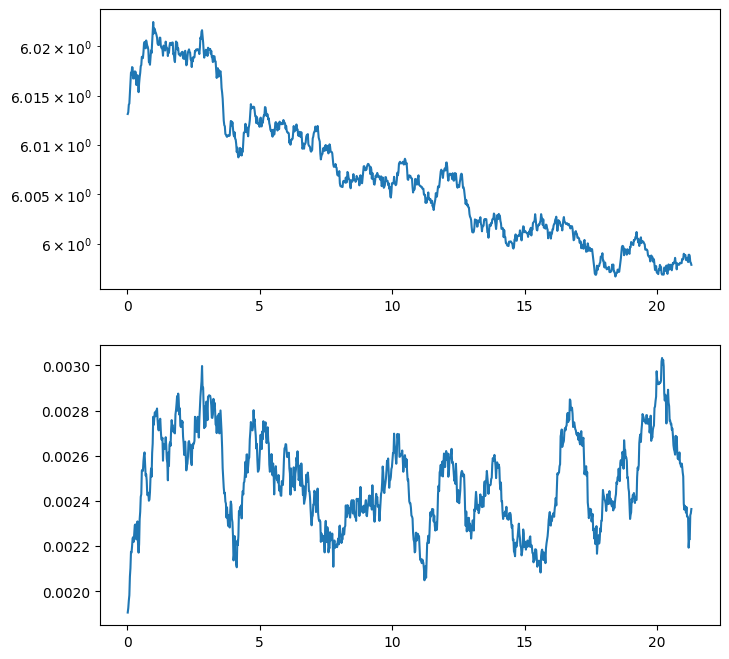

In [91]:
import matplotlib.pyplot as plt
from scipy import ndimage

filter_width = 50

fig,axes = plt.subplots(2,1,figsize=(8,8))
ax = axes[0]
ax.semilogy(stats.epoch, ndimage.uniform_filter1d(stats.loss,filter_width))
ax = axes[1]
ax.plot(stats.epoch, ndimage.uniform_filter1d(stats.accuracy,filter_width))

In [ ]:
state = TrainState.make(
    arc_cls,
    TrainConfig(),
    rngs=nnx.Rngs(0),
)
state.tx.